# Dataset Generation

This is simple research effort to evaluate how well motion planning heuristics can be approximated via learning based function approximators (i.e. deep neural network architectures). 

The first step here is to generate a dataset of motion planning heuristics. For this purpose, I've chosen to generate a random environment in the form of occupancy grids. Then use Value iteration to construct a heat map that captures a heuristic of distance to final destination. The goal is to then try to approximate this heatmap given an input environment.

In [11]:
import numpy as np
from matplotlib import pyplot as plt

## Transition Matrix

Transition matrix describes the possible transition between all pairs of states.

In [12]:
def GetTransitionMatrix(D):
    n = D.shape[0]
    total = n*n
    transitionMatrix = np.zeros((total,total))
    for k in range(total):
        i = k//n
        j = k%n
        
        if D[i,j] > 0:
            continue
        
        up   = i - 1
        down = i + 1
        left = j - 1
        right = j + 1  
        
        if up >= 0 and D[up,j] < 1:
            nextI = up*n + j
            transitionMatrix[k,nextI] = 1
        
        if down < n and D[down,j] < 1:
            nextI = down*n + j
            transitionMatrix[k,nextI] = 1
            
        if left >= 0 and D[i,left] < 1:
            nextI = i*n + left
            transitionMatrix[k,nextI] = 1
        
        if right < n and D[i,right] < 1:
            nextI = i*n + right
            transitionMatrix[k,nextI] = 1
            
            
        den = np.sum(transitionMatrix[k,:])
        if den > 0:
            transitionMatrix[k,:] = transitionMatrix[k,:]/den
        
    return transitionMatrix
                

## Value Iteration

In [13]:
def RunValueIteration(V,T,R):
    err = 100
    Vnew = V
    gamma = 0.99
    while err > 1e-5:
        Vnew = R + gamma*np.dot(T,V)
        err = np.linalg.norm(Vnew-V)
        V = Vnew
        #print(err)
    return Vnew

In [14]:
def ConvertV2Map(V,normalize=True):
    n = int(np.sqrt(V.shape[0]))
    M = np.zeros((n,n))
    for k in range(V.shape[0]):
        i = k//n
        j = k%n
        M[i,j] = V[k]
    
    if normalize:
        M = M/np.max(M)
    return M

In [15]:
def GenerateData(mapSize,obsprob=0.7,test=None):
    N = mapSize
    goali = min(int(np.random.rand(1)*10),N-1)
    goalj = min(int(np.random.rand(1)*10),N-1)
    if test is None:
        A = np.random.rand(N,N)
    else:
        A = test
    A[A >  obsprob] = 1
    A[A <= obsprob] = 0
    V0 = np.zeros((N*N,1))
    R = np.zeros((N*N,1))
    R[int(goali*N+goalj),0] = 1000
    A[goali,goalj] = 0.0
    T = GetTransitionMatrix(A)
    Vnew = RunValueIteration(V0,T,R)
    M = ConvertV2Map(Vnew)
    A[goali,goalj] = 0.5
    return (A,M)

In [16]:
def PlotMap(A,M):
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.imshow(A,cmap='Greys',vmin=0,vmax=1)
    ax2.imshow(M)

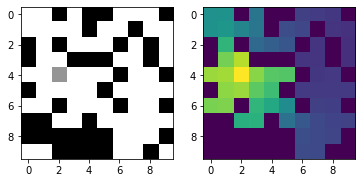

In [17]:
A,M = GenerateData(10,obsprob=0.7)
PlotMap(A,M)

In [8]:
import ray
ray.init()

# Generate dataset
imageSize = 10
dataSetSize = 50000

@ray.remote
# Wrap generator for multiprocessing
def f(_):
    return GenerateData(imageSize,obsprob=0.7)

2021-09-15 09:07:11,589	INFO services.py:1265 -- View the Ray dashboard at http://127.0.0.1:8266


In [9]:
import time
start = time.time()
futures = [f.remote(i) for i in range(dataSetSize)]
result = ray.get(futures)
end = time.time()
print(end-start)
with open('dataset_train.npy','wb') as fp:
    np.save(fp,np.array(result[:40000]))
    
with open('dataset_test.npy','wb') as fp:
    np.save(fp,np.array(result[40000:]))

242.14350485801697


In [ ]:
PlotMap(*result[0])